<a href="https://colab.research.google.com/github/pavankakadiya/Sentiment-Analysis-of-US-Airlines-using-Twitter-Data/blob/main/Sentiment_Analysis_of_U_S_Airlines_Using_Twitter_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download stopwords
nltk.download("stopwords")

sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [1]:
#Upload file
from google.colab import files

uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [4]:
df = pd.read_csv("Tweets.csv")

# Select relevant columns
df = df[
    [
        "tweet_id",
        "airline",
        "airline_sentiment",
        "airline_sentiment_confidence",
        "negativereason",
        "text",
        "tweet_created"
    ]
]

# Convert date column
df["tweet_created"] = pd.to_datetime(df["tweet_created"], errors="coerce")

df.head()


,tweet_id,airline,airline_sentiment,airline_sentiment_confidence,negativereason,text,tweet_created
0,570306133677760513,Virgin America,neutral,1.0000,NaN,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00
1,570301130888122368,Virgin America,positive,0.3486,NaN,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00
2,570301083672813571,Virgin America,neutral,0.6837,NaN,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00
3,570301031407624196,Virgin America,negative,1.0000,Bad Flight,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00
4,570300817074462722,Virgin America,negative,1.0000,Can't Tell,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00


In [5]:
#Check for missing values
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nSentiment distribution:\n", df["airline_sentiment"].value_counts())


Dataset shape: (14640, 7)

Missing values:
 tweet_id                           0
airline                            0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
text                               0
tweet_created                      0
dtype: int64

Sentiment distribution:
 airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [6]:
STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in STOPWORDS]

    return " ".join(tokens)


In [7]:
df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [8]:
#Sentiment Distribution by Airline Tabular
sentiment_by_airline = (
    df.groupby(["airline", "airline_sentiment"])
    .size()
    .reset_index(name="count")
)

sentiment_by_airline


,airline,airline_sentiment,count
0,American,negative,1960
1,American,neutral,463
2,American,positive,336
3,Delta,negative,955
4,Delta,neutral,723
5,Delta,positive,544
6,Southwest,negative,1186
7,Southwest,neutral,664
8,Southwest,positive,570
9,US Airways,negative,2263


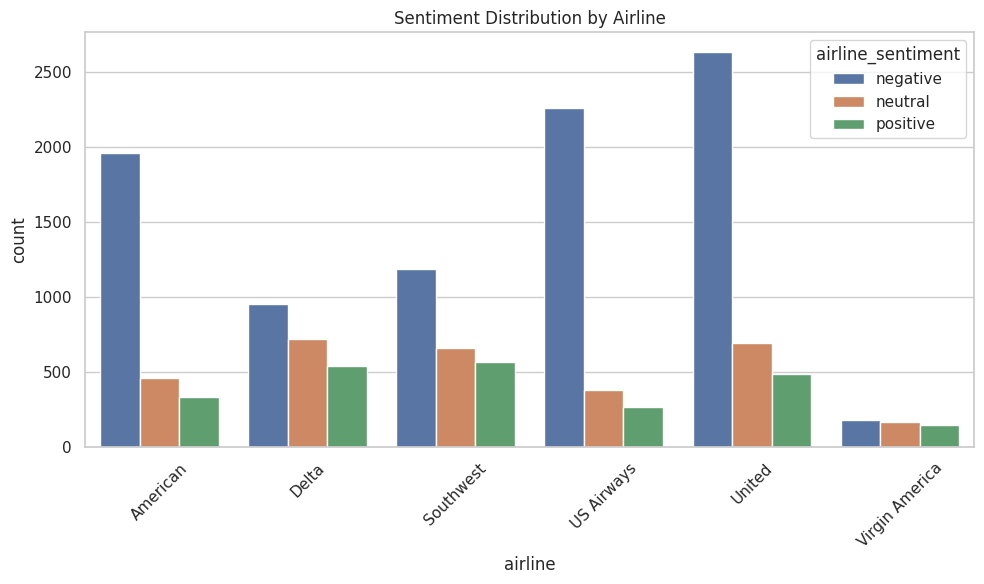

In [9]:
#Sentiment Distribution by Airline Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_by_airline,
    x="airline",
    y="count",
    hue="airline_sentiment"
)
plt.title("Sentiment Distribution by Airline")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
#Sentiment Trend Over Time - Tabular
df["date"] = df["tweet_created"].dt.date

sentiment_trend = (
    df.groupby(["date", "airline_sentiment"])
    .size()
    .reset_index(name="count")
)

sentiment_trend.head()


,date,airline_sentiment,count
0,2015-02-16,negative,3
1,2015-02-16,neutral,1
2,2015-02-17,negative,838
3,2015-02-17,neutral,297
4,2015-02-17,positive,273


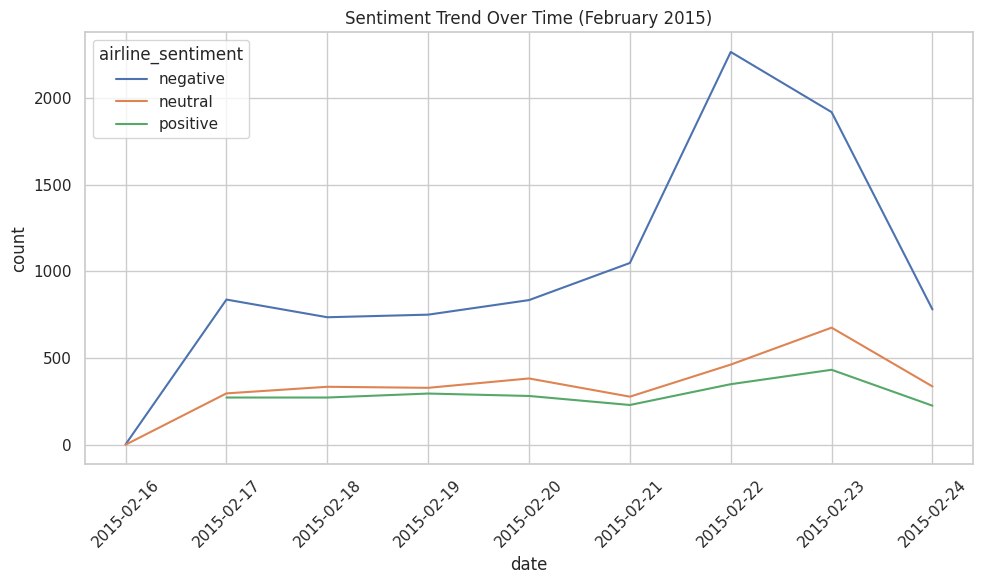

In [11]:
#Sentiment Trend Over Time - Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=sentiment_trend,
    x="date",
    y="count",
    hue="airline_sentiment"
)
plt.title("Sentiment Trend Over Time (February 2015)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
#Reasons for Negative Sentiment
negative_reasons = (
    df[df["airline_sentiment"] == "negative"]["negativereason"]
    .value_counts()
    .reset_index()
)

negative_reasons.columns = ["reason", "count"]
negative_reasons.head(10)


,reason,count
0,Customer Service Issue,2910
1,Late Flight,1665
2,Can't Tell,1190
3,Cancelled Flight,847
4,Lost Luggage,724
5,Bad Flight,580
6,Flight Booking Problems,529
7,Flight Attendant Complaints,481
8,longlines,178
9,Damaged Luggage,74


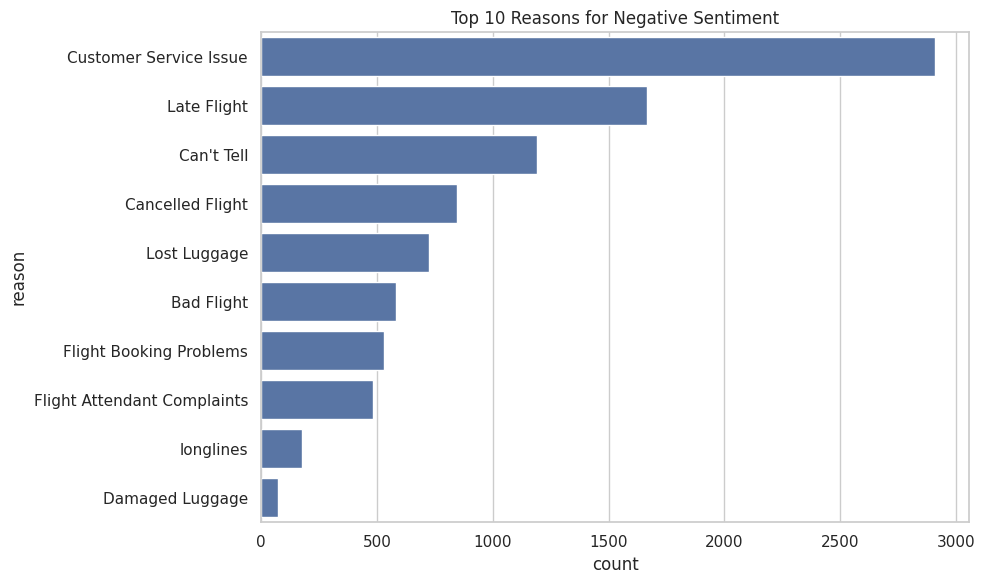

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=negative_reasons.head(10),
    x="count",
    y="reason"
)
plt.title("Top 10 Reasons for Negative Sentiment")
plt.tight_layout()
plt.show()


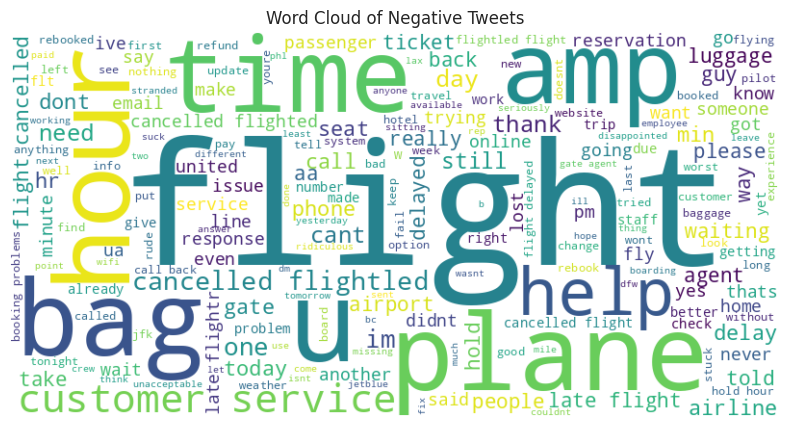

In [14]:
#Word Cloud of Negative Tweets
negative_text = " ".join(
    df[df["airline_sentiment"] == "negative"]["clean_text"]
)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Negative Tweets")
plt.show()
